# Étape 1 : Importer les dépendances ; charger et analyser les données de texte de spam

Bibliothèques externes pour lire et explorer les données – NumPy, Pandas, Seaborn, Matplotlib, word cloud

Bibliothèque de splitting de données – Sklearn

Bibliothèque pour deep learning - TensorFlow

In [40]:
# importing libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Bidirectional

**Par la suite on va charger notre dataset a partir du drive comme l'indiquant le path**

In [41]:
# load and explore the data
messages = pd.read_csv('spam.csv',encoding="latin-1")
messages= messages.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])
messages=messages.rename(columns={"v1": "label", "v2": "message"})



---

**on va minimiser la taille de notre dataset tout en supprimant les messages dublicated qui existent**

---



In [42]:
#remove duplicated rows
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [43]:
#group messages from dataset by labels
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

Il y a 4 825 messages indésirables et 747 spams. Cela indique que les données sont déséquilibrées et doivent être corrigées.

Le premier message de jambon est "Sorry, I’ll call later", tandis que le premier message de spam est "Please call our customer service…" qui s'est produit 30 et 4 fois, respectivement.

créons une trame de données distincte pour les messages de ham et de spam et convertissons-la en tableau NumPy, puis en une liste pour générer WordCloud plus tard.

In [44]:
# Get all the ham and spam messages
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_txt = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_txt = " ".join(spam_msg.message.to_numpy().tolist())

Créons maintenant notre wordcloud, pour extraire les mots les plus fréquents 
dans les messages ham

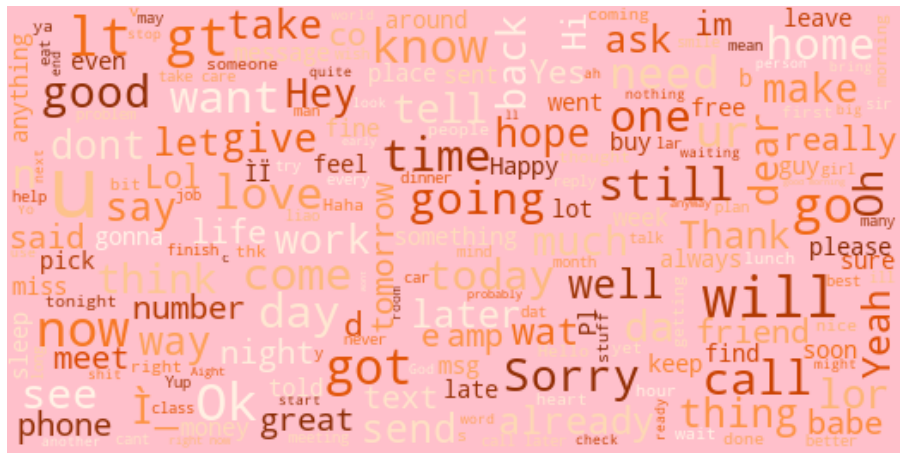

In [45]:
#remove all the stopwords (it's considered as unnecassary data)
# wordcloud of ham messages
ham_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="pink", colormap='Oranges').generate(ham_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Le message ham WordCloud ci-dessus montre que “love”, “will”, “come”, “now” and “time” sont les mots les plus courants dans les messages ham

word cloud pour spam aussi


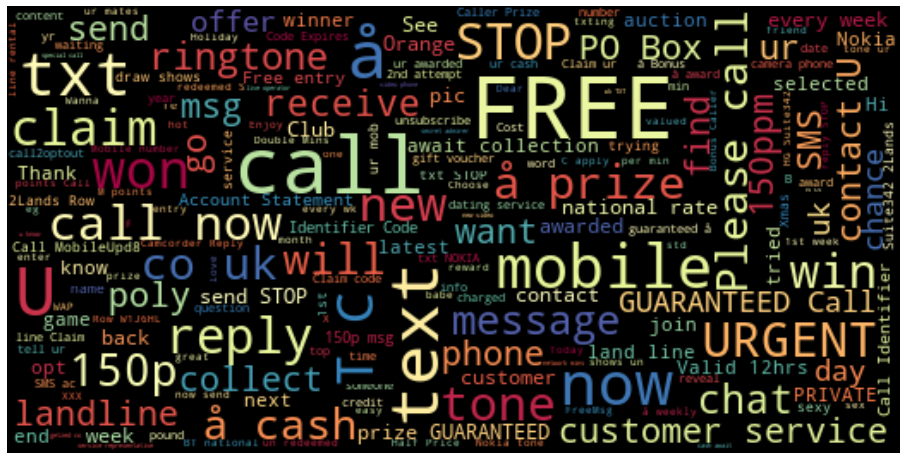

In [46]:
# wordcloud of spam messages
spam_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Spectral_r').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Le message de spam WordCloud ci-dessus montre que “FREE”, “call”, “text”, “GUARANTEED” et “win” sont les mots les plus courants dans les messages de spam.

tracer un graphique à barres pour estimer le pourcentage de spam et ham

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


15.481865284974095

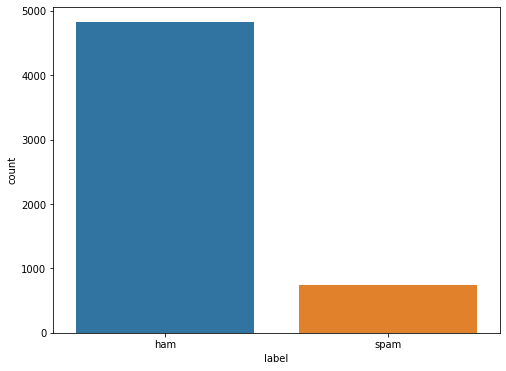

In [47]:
#visualize imbalanced data 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 

*cela montre clairement que le pourcentage de spams est d'environ 15,48%. On peut donc estimer que le pourcentage de ham et de spam est respectivement de 85% et 15%.*

mettons en œuvre la méthode de sous-échantillonnage pour nos données déséquilibrées

(747, 2) (747, 2)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message labels')

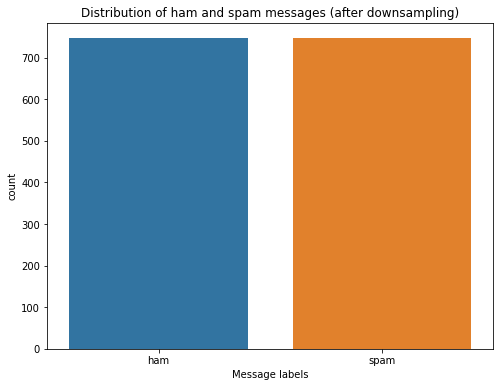

In [48]:
# one way to fix imbalanced data is to downsample the ham message count to the spam message count
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

#check the shape now, it must be te same!
print(ham_msg_df.shape, spam_msg_df.shape)

#check graph for better visualization 
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam messages (after downsampling)')
plt.xlabel('Message labels')

Le nombre de spams et de hams est le même

In [49]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,69.626506
spam,138.866131


# Étape 2 prétraitement du texte : diviser les données en sous-ensembles de données d'entraînement et de test

In [50]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

Prétraiter le texte pour le rendre  adapté à l'analyse, à la modélisation et 
la prédiction

In [51]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

tokeniser les mots en représentation numérique

In [52]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [53]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [54]:
# check how many unique tokens are present
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


In [55]:
# Sequencing and padding 
#train
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

#test
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

# Étape 3 : Entraînez


In [56]:
vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

In [57]:
#Dense Sequential model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [59]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [60]:
# fit dense seq model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3) #Les rappels vous permettent de spécifier la mesure de performance pour surveiller le déclencheur, et une fois déclenché, il arrêtera le processus de formation
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6892 - accuracy: 0.6050 - val_loss: 0.6821 - val_accuracy: 0.7324 - 906ms/epoch - 24ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6702 - accuracy: 0.7975 - val_loss: 0.6541 - val_accuracy: 0.8395 - 101ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6224 - accuracy: 0.8628 - val_loss: 0.5907 - val_accuracy: 0.8562 - 102ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5419 - accuracy: 0.8720 - val_loss: 0.5042 - val_accuracy: 0.8763 - 110ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4468 - accuracy: 0.8854 - val_loss: 0.4165 - val_accuracy: 0.8863 - 107ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3634 - accuracy: 0.9013 - val_loss: 0.3472 - val_accuracy: 0.8896 - 103ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3004 - accuracy: 0.9121 - val_loss: 0.2948 - val_accuracy: 0.9030 - 102ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2497 - accuracy: 0.9305 - val_loss: 0.2495 - val_accuracy: 0.9130 - 93ms/epoch - 2ms/step
Epoch 9/30
38/38

In [61]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.9699


[0.08138270676136017, 0.9698996543884277]

les résultats obtenues sont :
training loss: 0.0919
training accuracy : 0.98
validation loss : 0.0919
validation accuracy: 0.9632

La perte d'entraînement et la perte de validation sont relativement faibles, ce qui est un signe que le modèle est en mesure de prédire les valeurs cibles avec une certaine précision. Cela peut indiquer que le modèle est en mesure de généraliser ses prédictions à de nouvelles données.

La précision de l'entraînement est supérieure à celle de la validation. Cela peut indiquer un certain degré de surapprentissage, ce qui signifie que le modèle a appris de manière trop précise les données d'entraînement et peut ne pas généraliser de manière aussi efficace à de nouvelles données. 

La précision de l'entraînement et de la validation est relativement élevée, ce qui est un signe que le modèle fonctionne bien. Cela peut indiquer que le modèle est en mesure de prédire avec une certaine précision les valeurs cibles pour les données d'entraînement et de validation.

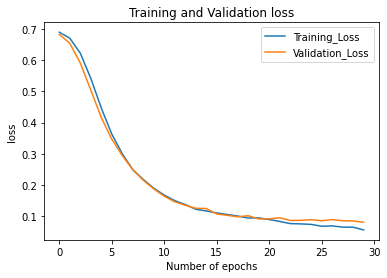

In [62]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

**Le graph ci-dessus montre que la précision augmente au fil des époques croissantes. Comme prévu, le modèle fonctionne mieux dans l'ensemble d'apprentissage que dans l'ensemble de validation**

essaie du détecteur de spam

In [63]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 81ms/step


array([[0.00176037],
       [0.01245515],
       [0.9997103 ]], dtype=float32)

Comme vous pouvez le voir ci-dessus, la troisième entrée de notre message d'entrée a une estimation de 99% de **spam**